In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"


Then you need to install Git-LFS to upload your model checkpoints:

# Load Dataset

In [2]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    # output_dir = 'ddpm-butterflies-128'  # the model namy locally and on the HF Hub
    output_dir = 'ddpm-flower-shifted-cos-128-32-small-sig'  # the model namy locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

In [3]:
from datasets import load_dataset

config.dataset = "nelorth/oxford-flowers"
train_dataset = load_dataset(config.dataset, split="train")
test_dataset = load_dataset(config.dataset, split="test")


In [4]:
from torchvision import transforms

train_preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.5], [0.5]),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]
)
test_preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.ToTensor(),
        # transforms.Normalize([0.5], [0.5]),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]
)

In [5]:
reverse_transform = transforms.Compose([
     transforms.Lambda(lambda t: (t + 1) / 2),
     transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     transforms.Lambda(lambda t: t * 255.),
     transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
     transforms.ToPILImage(),
])

In [6]:
def train_transform(examples):
    images = [train_preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}
def test_transform(examples):
    images = [test_preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}
    
train_dataset.set_transform(train_transform)
test_dataset.set_transform(test_transform)

In [7]:
import torch

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False)

In [8]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
      ),
)

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.1+cu121 with CUDA 1201 (you have 2.0.1)
    Python  3.9.18 (you have 3.9.18)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


Let's get a sample image from our dataset and pass it into our model. We just need to add a batch dimension:

In [9]:
sample_image = test_dataset[0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)

Input shape: torch.Size([1, 3, 128, 128])


And let's check the output is a tensor of the same exact shape:

In [10]:
print('Output shape:', model(sample_image, timestep=0)["sample"].shape)

Output shape: torch.Size([1, 3, 128, 128])


In [26]:
from diffusers import DDPMScheduler

timesteps = 1000

# noise_scheduler = DDPMScheduler(num_train_timesteps=timesteps, tensor_format="pt")
# noise_scheduler = DDPMScheduler(num_train_timesteps=timesteps)
noise_scheduler = DDPMScheduler(num_train_timesteps=timesteps, beta_schedule="squaredcos_cap_v2")

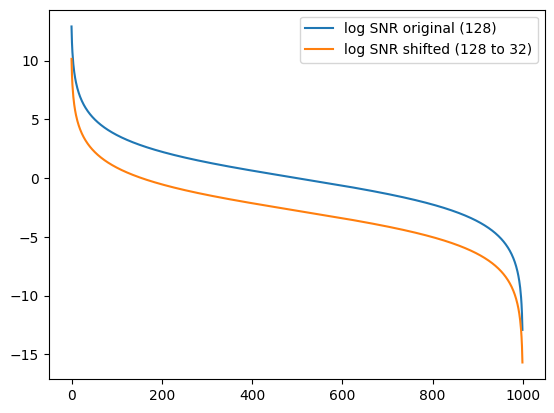

In [27]:
import math
import matplotlib.pyplot as plt

# s = 0.001
s = 0.001
shifted_scale = 4

x = torch.Tensor(list(range(timesteps)))

# cosine_log_snr = [math.log(noise_scheduler.alphas_cumprod[i] / (1 - noise_scheduler.alphas_cumprod[i])) for i in range(timesteps)]
cosine_log_snr = [math.log(alphas_cumprod / (1 - alphas_cumprod)) for alphas_cumprod in torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2]
plt.plot(cosine_log_snr, label='log SNR original (128)')

shifted_cosine_log_snr = [-math.log(snr) + 2 * math.log(1/shifted_scale) for snr in torch.tan(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2]
plt.plot(shifted_cosine_log_snr, label='log SNR shifted (128 to 32)')


plt.legend()
plt.show()

noise_scheduler.alphas_cumprod = torch.sigmoid(torch.Tensor(shifted_cosine_log_snr))
# noise_scheduler.betas = torch.sigmoid(-torch.Tensor(shifted_cosine_log_snr))

In [66]:
# plt.plot([math.sqrt(i) for i in noise_scheduler.alphas_cumprod], label='alpha original (128)', color='C0')
# plt.plot([math.sqrt(1 - i) for i in noise_scheduler.alphas_cumprod], label='sigma original (128)', color='C0', linestyle='--')
# plt.legend()
# plt.show()

In [67]:
# plt.plot([math.sqrt(i) for i in noise_scheduler.alphas_cumprod], label='alpha shifed (128 to 32)', color='C1')
# plt.plot([math.sqrt(1 - i) for i in noise_scheduler.alphas_cumprod], label='sigma shifed (128 to 32)', color='C1', linestyle='--')
# plt.legend()
# plt.show()

In [68]:
import torch.nn.functional as F
import numpy as np
# define alphas
alphas_cumprod_prev = F.pad(noise_scheduler.alphas_cumprod[:-1], (1, 0), value=1.0)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(noise_scheduler.alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - noise_scheduler.alphas_cumprod)

# def extract(a, t, x_shape):
#     batch_size = t.shape[0]
#     out = a.gather(-1, t.cpu())
#     return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
    
# # forward diffusion
# def q_sample(x_start, t, noise=None):
#     if noise is None:
#         noise = torch.randn_like(x_start)

#     sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
#     sqrt_one_minus_alphas_cumprod_t = extract(
#         sqrt_one_minus_alphas_cumprod, t, x_start.shape
#     )

#     return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
def q_sample(original_samples, timesteps, noise=None):
    if noise is None:
        noise = torch.randn_like(original_samples)
        
    sqrt_alpha_prod = noise_scheduler.alphas_cumprod[timesteps] ** 0.5
    sqrt_alpha_prod = sqrt_alpha_prod.flatten()
    while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
        sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

    sqrt_one_minus_alpha_prod = (1 - noise_scheduler.alphas_cumprod[timesteps]) ** 0.5
    sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
    while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

    noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
    return noisy_samples
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image
    
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()
    plt.savefig(f'savefig/noisy_{config.output_dir}.png')
    
plot([get_noisy_image(sample_image, torch.tensor([t])) for t in [0, 250, 500, 750, 999]])
# plot([get_noisy_image(sample_image, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

In [69]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

In [45]:
noise_scheduler.config.keys()

odict_keys(['num_train_timesteps', 'beta_start', 'beta_end', 'beta_schedule', 'trained_betas', 'variance_type', 'clip_sample', 'prediction_type', '_class_name', '_diffusers_version'])

 And a cosine learning rate schedule:

In [15]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

To evaluate our model, we use the `DDPMPipeline` which is an easy way to perform end-to-end inference (see this notebook [TODO link] for more detail). We will use this pipeline to generate a batch of sample images and save it as a grid to the disk.

In [16]:
from diffusers import DDPMPipeline
from PIL import Image
import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

@torch.no_grad()
def evaluate(config, epoch, pipeline, model, test_dataloader):
    model.eval()
    
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    )["images"]

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

    loss = 0.
    with torch.no_grad():
        for step, batch in enumerate(test_dataloader):
            clean_images = batch['images']
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]
        
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()
        
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
    
            noise_pred = model(noisy_images, timesteps)["sample"]
            loss += F.mse_loss(noise_pred, noise)

    with open(f'{config.output_dir}/log.txt', 'a') as f:
        f.write(f'{epoch}\t{loss}\n')

In [ ]:
@torch.no_grad()
def evaluate(config, epoch, pipeline, model, test_dataloader):
    model.eval()
    
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    )["images"]

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

    loss = 0.
    with torch.no_grad():
        for step, batch in enumerate(test_dataloader):
            clean_images = batch['images']
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]
        
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()
        
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
    
            noise_pred = model(noisy_images, timesteps)["sample"]
            loss += F.mse_loss(noise_pred, noise)

    with open(f'{config.output_dir}/log.txt', 'a') as f:
        f.write(f'{epoch}\t{loss}\n')

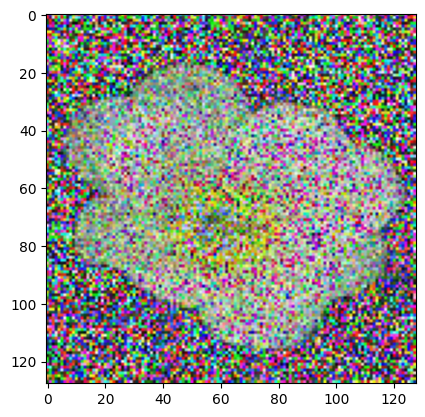

In [51]:
noisy_images = reverse_transform(noise_scheduler.add_noise(sample_image, torch.randn_like(sample_image), torch.tensor([60]))[0])
plt.imshow(noisy_images)

In [17]:
from accelerate import Accelerator
# from diffusers.hub_utils import init_git_repo, push_to_hub

from tqdm.auto import tqdm
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, test_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        # log_with="tensorboard",
        # logging_dir=os.path.join(config.output_dir, "logs")
    )
    # if accelerator.is_main_process:
    #     if config.push_to_hub:
    #         repo = init_git_repo(config, at_init=True)
    #     accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, test_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, test_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        model.train()
        
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps)["sample"]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline, model, test_dataloader)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                # if config.push_to_hub:
                #     push_to_hub(config, pipeline, repo, commit_message=f"Epoch {epoch}", blocking=True)
                # else:
                pipeline.save_pretrained(f'{config.output_dir}/{int(epoch)}')

## Let's train!

Let's launch the training (including multi-GPU training) from the notebook using Accelerate's `notebook_launcher` function:

In [ ]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, test_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Launching training on one GPU.


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

/home/nas4_user/saemeechoi/anaconda3/envs/tokenflow/lib/python3.9/site-packages/diffusers/pipelines/ddpm/pipeline_ddpm.py:89: FutureWarning: `generator.device == 'cpu'` is deprecated and will be removed in version 0.12.0. The `generator` device is `cpu` and does not match the pipeline device `cuda:0`, so the `generator` will be ignored. Please use `torch.Generator(device="cuda:0")` instead.
  deprecate(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

Let's have a look at the final image grid produced by the trained diffusion model:

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

Not bad! There's room for improvement of course, so feel free to play with the hyperparameters, model definition and image augmentations 🤗

If you've chosen to upload the model to the Hugging Face Hub, its repository should now look like so:
https://huggingface.co/anton-l/ddpm-butterflies-128

If you want to dive deeper into the code, we also have more advanced training scripts with features like Exponential Moving Average of model weights here:

https://github.com/huggingface/diffusers/tree/main/examples